In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# Model the age in normal distribution -> vul

In [2]:
class SEIR_model_gaussian_age:
    def __init__(self, timesteps, pop_sizes, prop_init_infected, betas, gamma, sigma, alpha, beta_vul, age_dist_params, mobility_factors, age_samples=10000):
        self.T = timesteps
        self.pop_sizes = pop_sizes  # Population sizes for each group
        self.prop_init_infected = prop_init_infected  # Initial proportion of infected
        self.betas = betas  # Base transmission rates
        self.gamma = gamma  # Recovery rate
        self.sigma = sigma  # Rate from exposed to infectious
        self.alpha = alpha  # Age-based vulnerability parameter
        self.beta_vul = beta_vul  # Age-based vulnerability parameter
        self.age_dist_params = age_dist_params  # Mean and std dev of age for each group
        self.mobility_factors = mobility_factors  # Mobility factors for each group, contact frequency
        self.age_samples = age_samples  # To approximate age-based vulnerability

    def vulnerability(self, age):
        return np.exp(self.alpha * age + self.beta_vul)

    def vulnerability_age_simulation(self, grp_idx):
        age_mean, age_sd = self.age_dist_params[grp_idx]
        sampled_ages = np.random.normal(age_mean, age_sd, self.age_samples) ### question1: normal is not a good representation for age. 
        sampled_vulnerabilities = self.vulnerability(sampled_ages) # for each of the age, calculate vulnerability. 
        return np.mean(sampled_vulnerabilities)

    def adjust_betas(self):
        adj_betas = np.zeros_like(self.betas)
        for i in range(2):  # assuming two groups
            vul_i = self.vulnerability_age_simulation(i)
            for j in range(2):
                vul_j = self.vulnerability_age_simulation(j)
                # use the vulnerability of the group being infected and the mobility factor of the infecting group
                adj_betas[i, j] = self.betas[i, j] * vul_i * self.mobility_factors[j]
        print(adj_betas)
        return adj_betas
        # print(self.betas)
        return self.betas


    def simulate(self):
        # Initialize compartments for each group
        S, E, I, R = (np.zeros((2, self.T)) for _ in range(4))  
        
        # initial conditions
        for i in range(2):
            I[i, 0] = int(self.prop_init_infected[i] * self.pop_sizes[i])
            S[i, 0] = self.pop_sizes[i] - I[i, 0]
            # E[i, 0] = 1 / 20000
            # assuming no one is exposed or recovered initially

        # adjusted beta values
        adj_betas = self.adjust_betas()

        epsilon = self.sigma  # rate from exposed to infectious
        gamma1 = self.gamma  # recovery rate
        gamma2 = self.gamma  # secondary recovery rate 
        
        # simulation
        for t in range(1, self.T):
            for i in range(2):  # for each group
                beta_E = adj_betas[i, 0]  # transmission rate due to exposed ind
                beta_I = adj_betas[i, 1]  # Transmission rate due to infected ind
                
                
                new_exposures = (beta_E * E[i, t-1] + beta_I * I[i, t-1]) * S[i, t-1] / self.pop_sizes[i]
                new_infections = epsilon * E[i, t-1]
                new_recoveries = gamma1 * I[i, t-1]

                # update
                # https://medium.com/@cd_24/a-simulation-of-the-spread-of-the-pandemic-seir-model-1728fbc9bc4c
                S[i, t] = S[i, t-1] - new_exposures
                E[i, t] = E[i, t-1] + new_exposures - new_infections
                I[i, t] = I[i, t-1] + new_infections - new_recoveries
                R[i, t] = R[i, t-1] + new_recoveries

                # no negative values
                S[i, t] = max(S[i, t], 0)
                E[i, t] = max(E[i, t], 0)
                I[i, t] = max(I[i, t], 0)
                R[i, t] = max(R[i, t], 0)

        return S, E, I, R

In [3]:
timesteps = 100
pop_sizes = [1000, 500]
prop_init_infected = [0.1, 0.2]

R0 = 4
t_infective = 5.1 + 3.3
gamma = 1/t_infective
beta = R0*gamma 

betas = np.array([[beta, 0.5 * beta], [0.5 * beta, beta]])

# sigma = 1/5
t_incubation = 7
sigma = 1 / t_incubation
alpha = 0.06
beta_vul = -3
age_dist_params = [(30, 5), (40, 10)]  # Mean and std dev for age distributions
mobility_factors = [1.5, 1]  # Mobility factors for each group

# Initialize and run the model
model = SEIR_model_gaussian_age(timesteps, pop_sizes, prop_init_infected, betas, gamma, sigma, alpha, beta_vul, age_dist_params, mobility_factors)
S, E, I, R = model.simulate()

[[0.22521589 0.07507196]
 [0.23431334 0.31241778]]


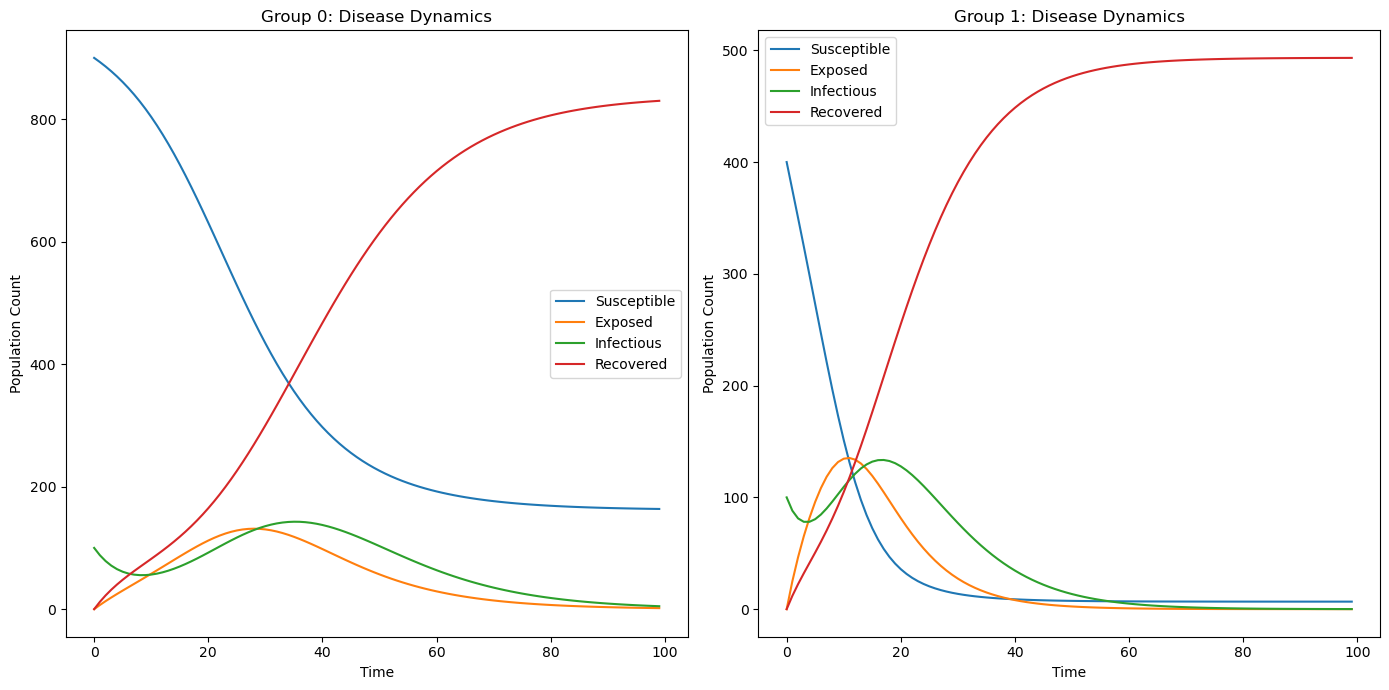

In [4]:
t = np.arange(timesteps)

# Plot for group 0 
# low mobility
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # Two subplots for two groups
plt.plot(t, S[0, :], label='Susceptible')
plt.plot(t, E[0, :], label='Exposed')
plt.plot(t, I[0, :], label='Infectious')
plt.plot(t, R[0, :], label='Recovered')
plt.title('Group 0: Disease Dynamics')
plt.xlabel('Time')
plt.ylabel('Population Count')
plt.legend()

# Plot for group 1
plt.subplot(1, 2, 2)
plt.plot(t, S[1, :], label='Susceptible')
plt.plot(t, E[1, :], label='Exposed')
plt.plot(t, I[1, :], label='Infectious')
plt.plot(t, R[1, :], label='Recovered')
plt.title('Group 1: Disease Dynamics')
plt.xlabel('Time')
plt.ylabel('Population Count')
plt.legend()

plt.tight_layout()
plt.show()

# Two separate groups for vul

In [39]:
class SEIR_model_age_vul:
    def __init__(self, timesteps, pop_sizes, prop_init_infected, betas, gamma, sigma, high_vul_factor, low_vul_factor, mobility_factors):
        self.T = timesteps
        self.pop_sizes = pop_sizes  
        self.prop_init_infected = prop_init_infected  
        self.betas = betas  
        self.gamma = gamma
        self.sigma = sigma  
        self.high_vul_factor = high_vul_factor 
        self.low_vul_factor = low_vul_factor  
        self.mobility_factors = mobility_factors 

    def adjust_betas(self):
        adj_betas = np.zeros_like(self.betas)
        adj_betas[0, :] = self.betas[0, :] * self.high_vul_factor * self.mobility_factors[0] 
        adj_betas[1, :] = self.betas[1, :] * self.low_vul_factor * self.mobility_factors[1]  
        return adj_betas

    def simulate(self):
        S, E, I, R = (np.zeros((2, self.T)) for _ in range(4))
        for i in range(2):
            I[i, 0] = int(self.prop_init_infected[i] * self.pop_sizes[i])
            S[i, 0] = self.pop_sizes[i] - I[i, 0]

        adj_betas = self.adjust_betas()

        for t in range(1, self.T):
            for i in range(2):  
                for j in range(2):  
                    beta_effective = adj_betas[i, j]
                    new_exposures = beta_effective * I[j, t-1] * S[i, t-1] / self.pop_sizes[j]
                    new_infections = self.sigma * E[i, t-1]
                    new_recoveries = self.gamma * I[i, t-1]

                    # Update compartments
                    S[i, t] = max(S[i, t-1] - new_exposures, 0)
                    E[i, t] = max(E[i, t-1] + new_exposures - new_infections, 0)
                    I[i, t] = max(I[i, t-1] + new_infections - new_recoveries, 0)
                    R[i, t] = max(R[i, t-1] + new_recoveries, 0)

        return S, E, I, R

In [40]:
timesteps = 100
pop_sizes = [1000, 500]  
prop_init_infected = [0.1, 0.2] 

R0 = 4
t_infective = 5.1 + 3.3  
gamma = 1 / t_infective  
beta = R0 * gamma 

betas = np.array([[beta, 0.5 * beta], [0.5 * beta, beta]])


t_incubation = 7
sigma = 1 / t_incubation  

high_vul_factor = 1.2 
low_vul_factor = 1.0  

mobility_factors = [1.5, 1] 

model = SEIR_model_age_vul(timesteps, pop_sizes, prop_init_infected, betas, gamma, sigma, high_vul_factor, low_vul_factor, mobility_factors)
S, E, I, R = model.simulate()

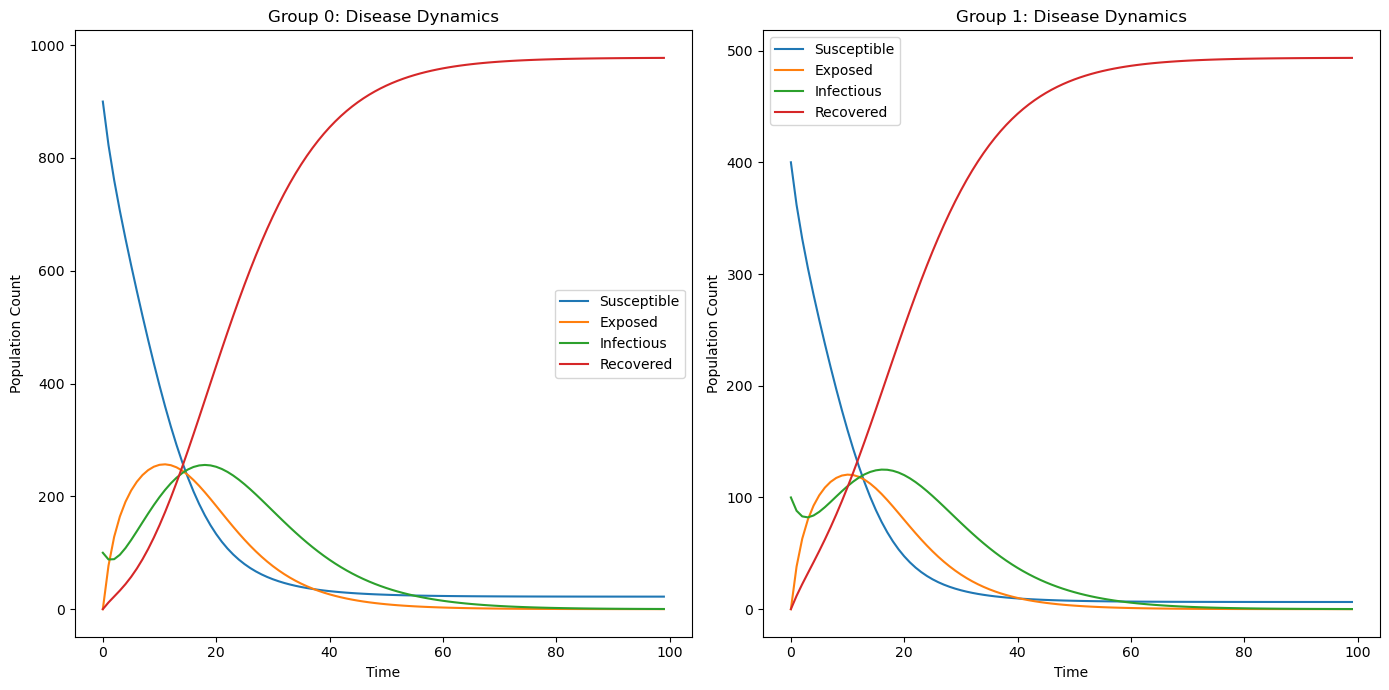

In [41]:
t = np.arange(timesteps)

# Plot for group 0 
# low mobility
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # Two subplots for two groups
plt.plot(t, S[0, :], label='Susceptible')
plt.plot(t, E[0, :], label='Exposed')
plt.plot(t, I[0, :], label='Infectious')
plt.plot(t, R[0, :], label='Recovered')
plt.title('Group 0: Disease Dynamics')
plt.xlabel('Time')
plt.ylabel('Population Count')
plt.legend()

# Plot for group 1
plt.subplot(1, 2, 2)
plt.plot(t, S[1, :], label='Susceptible')
plt.plot(t, E[1, :], label='Exposed')
plt.plot(t, I[1, :], label='Infectious')
plt.plot(t, R[1, :], label='Recovered')
plt.title('Group 1: Disease Dynamics')
plt.xlabel('Time')
plt.ylabel('Population Count')
plt.legend()

plt.tight_layout()
plt.show()

## Differential Equation Solver

In [6]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class SEIR_model_gaussian_age:
    def __init__(self, pop_sizes, prop_init_infected, betas, gamma, sigma, alpha, beta_vul, age_dist_params, mobility_factors):
        self.pop_sizes = pop_sizes
        self.prop_init_infected = prop_init_infected
        self.betas = betas
        self.gamma = gamma
        self.sigma = sigma
        self.alpha = alpha
        self.beta_vul = beta_vul
        self.age_dist_params = age_dist_params
        self.mobility_factors = mobility_factors

    def vulnerability(self, age):
        return np.exp(self.alpha * age + self.beta_vul)

    def adjust_betas(self, t):
        adj_betas = np.zeros_like(self.betas)
        for i in range(2):  # assuming two groups
            vul_i = self.vulnerability(self.age_dist_params[i][0])
            for j in range(2):
                vul_j = self.vulnerability(self.age_dist_params[j][0])
                adj_betas[i, j] = self.betas[i, j] * vul_i * self.mobility_factors[j]
        return adj_betas

    def seir_ode(self, y, t):
        S1, E1, I1, R1, S2, E2, I2, R2 = y
        N1 = sum(y[:4])
        N2 = sum(y[4:])
        adj_betas = self.adjust_betas(t)

        dS1dt = -adj_betas[0, 0] * S1 * I1 / N1
        dE1dt = adj_betas[0, 0] * S1 * I1 / N1 - self.sigma * E1
        dI1dt = self.sigma * E1 - self.gamma * I1
        dR1dt = self.gamma * I1

        dS2dt = -adj_betas[1, 1] * S2 * I2 / N2
        dE2dt = adj_betas[1, 1] * S2 * I2 / N2 - self.sigma * E2
        dI2dt = self.sigma * E2 - self.gamma * I2
        dR2dt = self.gamma * I2

        return [dS1dt, dE1dt, dI1dt, dR1dt, dS2dt, dE2dt, dI2dt, dR2dt]

    def simulate(self, timesteps):
        y0 = [self.pop_sizes[0] * (1 - self.prop_init_infected[0]),
              self.pop_sizes[0] * self.prop_init_infected[0],
              0, 0,
              self.pop_sizes[1] * (1 - self.prop_init_infected[1]),
              self.pop_sizes[1] * self.prop_init_infected[1],
              0, 0]
        t = np.arange(timesteps)
        sol = odeint(self.seir_ode, y0, t)
        return sol


In [9]:
pop_sizes = [1000, 500]
prop_init_infected = [0.1, 0.2]

R0 = 4
t_infective = 5.1 + 3.3
gamma = 1/t_infective
beta = R0 * gamma
betas = np.array([[beta, 0.5 * beta], [0.5 * beta, beta]])

t_incubation = 7
sigma = 1 / t_incubation
alpha = 0.06
beta_vul = -3
age_dist_params = [(30, 5), (40, 10)]  # Mean and std dev for age distributions
mobility_factors = [1.5, 1]  # Mobility factors for each group


model = SEIR_model_gaussian_age(pop_sizes, prop_init_infected, betas, gamma, sigma, alpha, beta_vul, age_dist_params, mobility_factors)
timesteps = 100
sol = model.simulate(timesteps)

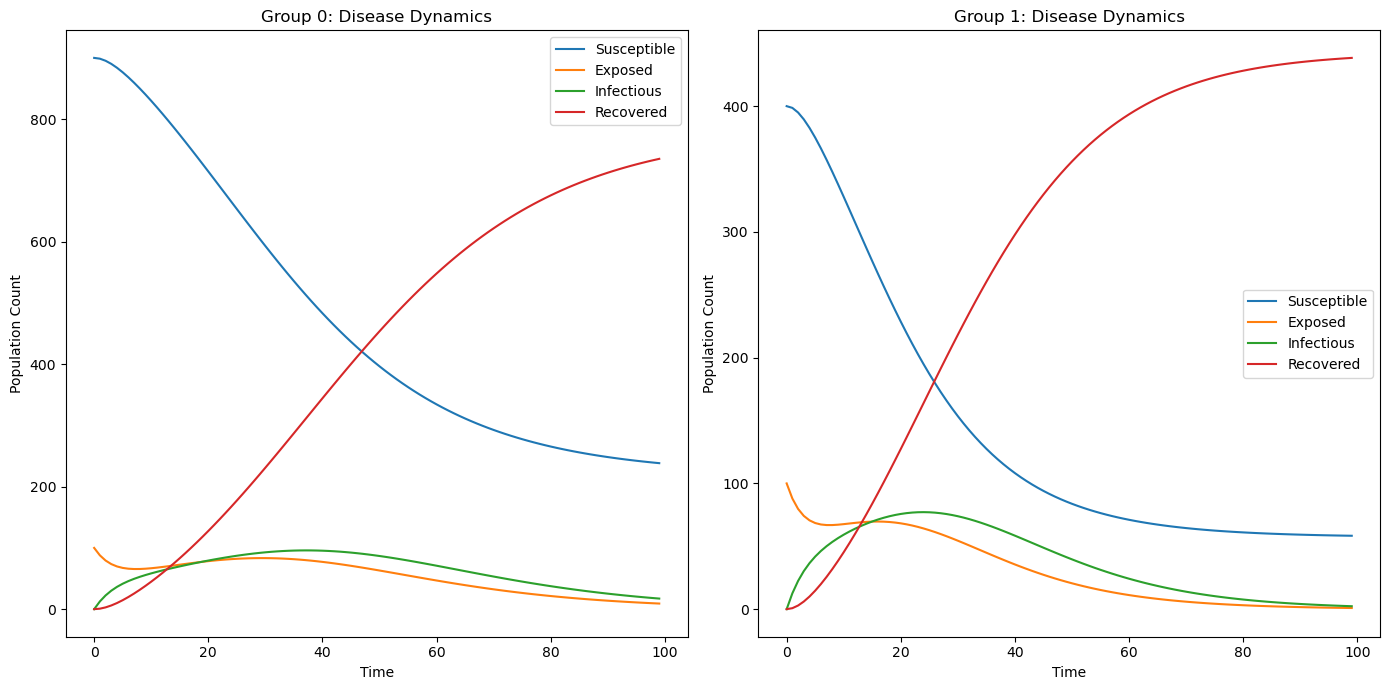

In [8]:
t = np.arange(timesteps)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # Two subplots for two groups
plt.plot(t, sol[:, 0], label='Susceptible')
plt.plot(t, sol[:, 1], label='Exposed')
plt.plot(t, sol[:, 2], label='Infectious')
plt.plot(t, sol[:, 3], label='Recovered')
plt.title('Group 0: Disease Dynamics')
plt.xlabel('Time')
plt.ylabel('Population Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, sol[:, 4], label='Susceptible')
plt.plot(t, sol[:, 5], label='Exposed')
plt.plot(t, sol[:, 6], label='Infectious')
plt.plot(t, sol[:, 7], label='Recovered')
plt.title('Group 1: Disease Dynamics')
plt.xlabel('Time')
plt.ylabel('Population Count')
plt.legend()

plt.tight_layout()
plt.show()